# Clustering e Classificazione

### Preprocessing

In [1]:
! pip install scikit-learn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder

In [3]:
df = pd.read_csv('df')

In [4]:
df.columns

Index(['id_student', 'gender', 'region', 'highest_education', 'imd_band',
       'age_band', 'studied_credits_x', 'disability', 'code_module',
       'code_presentation', 'num_of_prev_attempts', 'final_result',
       'module_presentation_length', 'total_clicks', 'assessment_type',
       'weight', 'score', 'registration', 'submission'],
      dtype='object')

Rimuoviamo le features non utili allo studio.

In [5]:
df = df.drop(['id_student', 'code_module', 'code_presentation'], axis =1)

In [6]:
df.columns

Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'studied_credits_x', 'disability', 'num_of_prev_attempts',
       'final_result', 'module_presentation_length', 'total_clicks',
       'assessment_type', 'weight', 'score', 'registration', 'submission'],
      dtype='object')

### Encoding delle features

In [7]:
scaler = MinMaxScaler()
num_cols = df.select_dtypes('number').columns
num_data = df[num_cols].copy()
scaled_num_cols = scaler.fit_transform(num_data)

In [8]:
scaled_df = pd.DataFrame(scaled_num_cols, columns=num_cols)

In [9]:
encoder = OneHotEncoder(sparse_output=False)
cat_cols = df.select_dtypes('object').columns
cat_data = df[cat_cols].copy()
encoded_cat_cols = encoder.fit_transform(cat_data)
feature_names = encoder.get_feature_names_out(cat_cols)

In [10]:
encoded_df = pd.DataFrame(encoded_cat_cols, columns=feature_names, index=df.index)

In [11]:
final_df = pd.concat([scaled_df, encoded_df], axis = 1)

## Clustering

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [13]:
# Checking different scores for different amount of clusters to find
def kmeans_optimization(data, max_k):

    # Initializing three lists: one to check the k that is being analyzed, the other to collect the niertias and silhouettes for each iteration
    ks = []
    inertias = []
    sil_scores = []

    best_sil = -1
    best_k = 0

    for k in range(2, max_k+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=16000)
        kmeans.fit_predict(data)

        ks.append(k)
        inertias.append(kmeans.inertia_)
        sil_score = silhouette_score(data, kmeans.labels_)
        sil_scores.append(sil_score)
        if sil_score > best_sil:
            best_sil = sil_score
            best_k = k

    # Genero il plot per inertia
    fig = plt.subplots(figsize = (10,5))
    plt.plot(ks, inertias, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia (SSE)')
    plt.grid(True)
    plt.show()

    # Genero il plot per la silhouette
    fig = plt.subplots(figsize = (10,5))
    plt.plot(ks, sil_scores, 'o-', color = 'orange')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Scores')
    plt.grid(True)
    plt.show()

    print(f'The best silhouette score was {best_sil} with a k of {best_k}')

In [14]:
kmeans_optimization(final_df, 6)

KeyboardInterrupt: 

In [15]:
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(final_df)
#final_df['cluster_label'] = labels

Visualizzazione

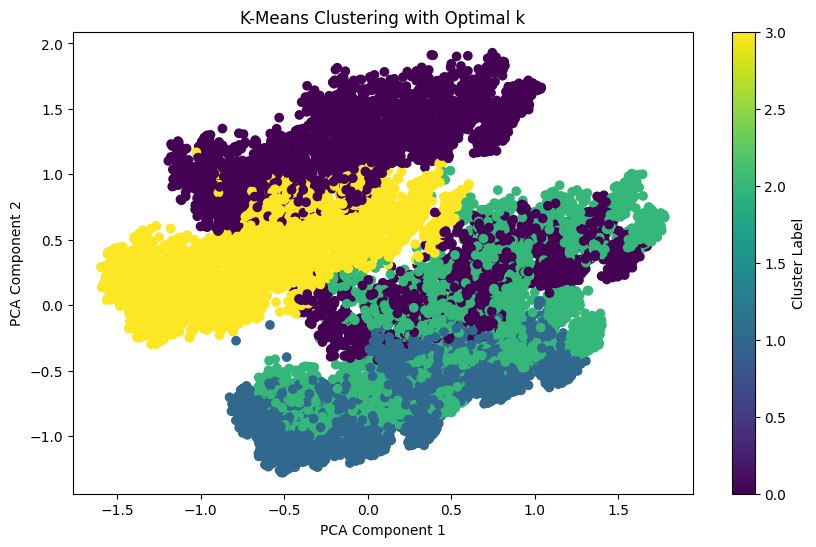

In [ ]:
pca = PCA(n_components=2, random_state=42)
pca_df = pca.fit_transform(final_df)

plt.figure(figsize=(10, 6))
plt.scatter(pca_df[:, 0], pca_df[:, 1], c=labels, cmap='viridis')
plt.title('K-Means Clustering with Optimal k')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

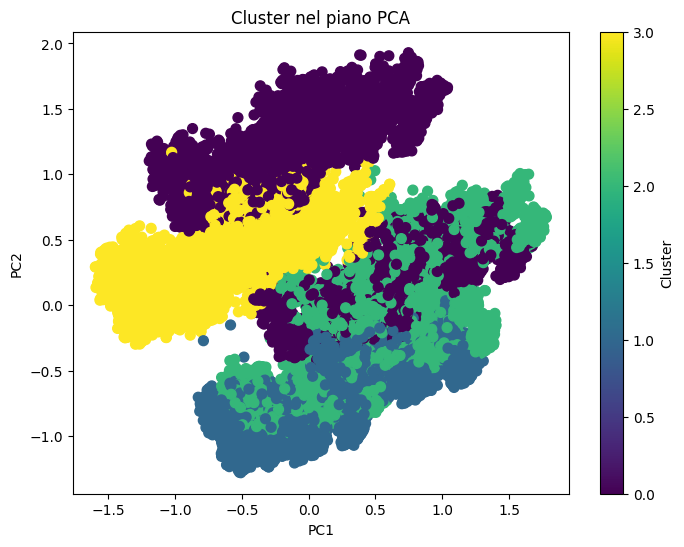

In [ ]:
# Scatter dei cluster nel piano PCA
import matplotlib.pyplot as plt

X_pca = pca.transform(final_df)  # se avevi scalato i dati
clusters = kmeans.labels_

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='viridis', s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cluster nel piano PCA')
plt.colorbar(label='Cluster')
plt.show()



In [ ]:
# Aggiungi i cluster
df['cluster'] = kmeans.labels_

# Separiamo variabili numeriche e categoriche
df_num = df.select_dtypes(include='number')
df_cat = df.select_dtypes(exclude='number')

# Raggruppiamo per cluster
mean_numeric = df_num.groupby(df['cluster']).mean()
mode_categorical = df_cat.groupby(df['cluster']).agg(lambda x: x.value_counts().index[0])

# Uniamo le due viste
cluster_summary = pd.concat([mean_numeric, mode_categorical], axis=1)
cluster_summary


,studied_credits_x,num_of_prev_attempts,module_presentation_length,weight,score,cluster,gender,region,highest_education,imd_band,age_band,disability,final_result,total_clicks,assessment_type,registration,submission
cluster,,,,,,,,,,,,,,,,,
0,79.876697,0.167292,251.591822,11.657203,69.934204,0.0,F,Scotland,A Level or Equivalent,10-20,0-35,N,Pass,very_low,CMA,iscrizione fortemente tardiva,late_submission
1,77.419506,0.125395,258.276832,18.827267,73.396097,1.0,M,Scotland,A Level or Equivalent,10-20,0-35,N,Pass,very_low,TMA,iscrizione_fortemente_anticipata,submission_on_time
2,78.026612,0.185164,256.633083,14.863298,68.135427,2.0,F,East Anglian Region,Lower Than A Level,10-20,0-35,N,Pass,very_low,TMA,iscrizione_fortemente_anticipata,submission_on_time
3,71.301144,0.113651,257.037242,7.131101,79.264655,3.0,M,South Region,A Level or Equivalent,10-20,0-35,N,Pass,very_high,CMA,iscrizione fortemente tardiva,submission_on_time


In [ ]:
all_feature_names = final_df.columns.tolist()

In [ ]:
pc1_loadings = pd.Series(pca.components_[0], index=all_feature_names)

top_pc1_features = pc1_loadings.abs().sort_values(ascending=False).head(10)

print("Top 10 feature più influenti su PC1:")
print(top_pc1_features)


Top 10 feature più influenti su PC1:
gender_F                         0.403533
gender_M                         0.403533
assessment_type_TMA              0.383959
assessment_type_CMA              0.383781
total_clicks_very_low            0.326431
final_result_Pass                0.255290
final_result_Fail                0.183842
total_clicks_very_high           0.183243
submission_late_submission       0.180456
submission_submission_on_time    0.180456
dtype: float64


In [ ]:
from sklearn.tree import DecisionTreeClassifier

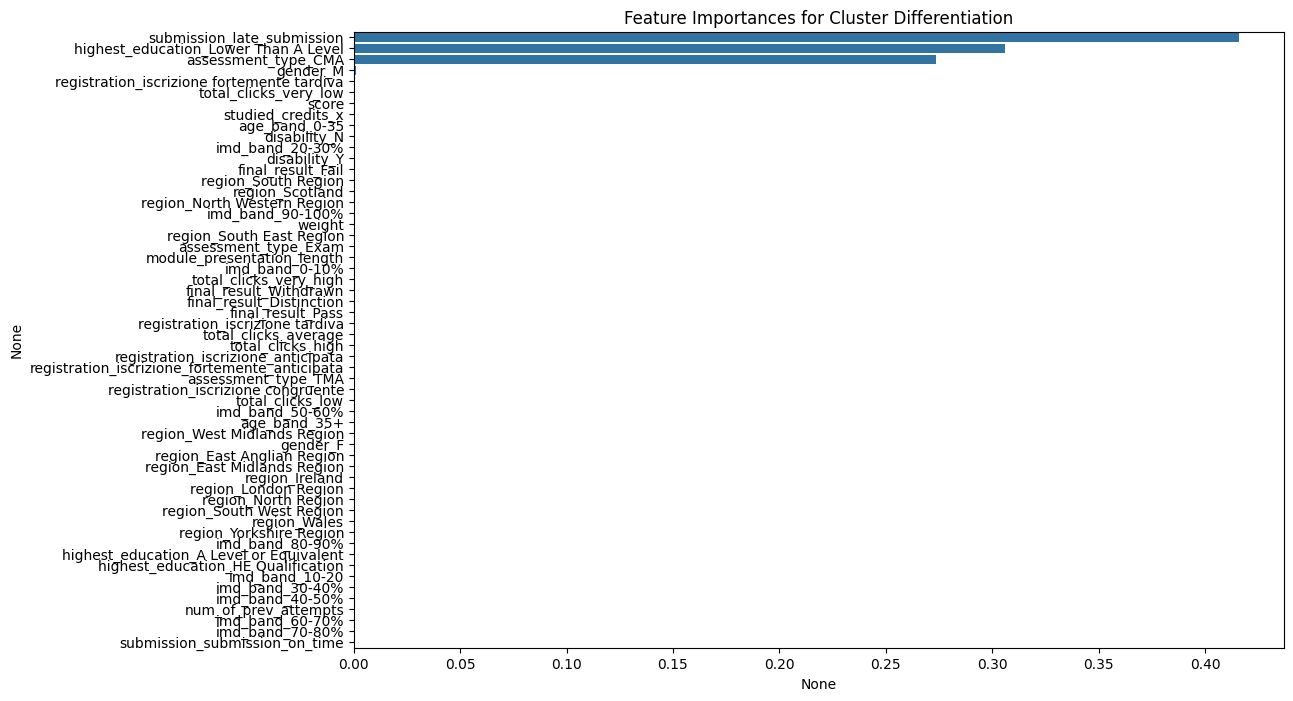

In [ ]:
targets_cluster = final_df['cluster_label']
features_cluster = final_df.drop('cluster_label', axis = 1)

model = DecisionTreeClassifier(random_state=42)
model.fit(features_cluster, targets_cluster)

feature_importances = pd.Series(model.feature_importances_, index=features_cluster.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importances for Cluster Differentiation')
plt.show()

#### Solo con features di engagement

In [ ]:
final_df.columns

Index(['studied_credits_x', 'num_of_prev_attempts',
       'module_presentation_length', 'weight', 'score', 'gender_F', 'gender_M',
       'region_East Anglian Region', 'region_East Midlands Region',
       'region_Ireland', 'region_London Region', 'region_North Region',
       'region_North Western Region', 'region_Scotland',
       'region_South East Region', 'region_South Region',
       'region_South West Region', 'region_Wales',
       'region_West Midlands Region', 'region_Yorkshire Region',
       'highest_education_A Level or Equivalent',
       'highest_education_HE Qualification',
       'highest_education_Lower Than A Level', 'imd_band_0-10%',
       'imd_band_10-20', 'imd_band_20-30%', 'imd_band_30-40%',
       'imd_band_40-50%', 'imd_band_50-60%', 'imd_band_60-70%',
       'imd_band_70-80%', 'imd_band_80-90%', 'imd_band_90-100%',
       'age_band_0-35', 'age_band_35+', 'disability_N', 'disability_Y',
       'final_result_Distinction', 'final_result_Fail', 'final_result_Pas

In [ ]:
cols_eng = ['studied_credits_x', 'num_of_prev_attempts', 'total_clicks_average', 'total_clicks_high',
       'total_clicks_low', 'total_clicks_very_high', 'total_clicks_very_low', 'registration_iscrizione congruente',
       'registration_iscrizione fortemente tardiva',
       'registration_iscrizione tardiva', 'registration_iscrizione_anticipata',
       'registration_iscrizione_fortemente_anticipata',
       'submission_late_submission', 'submission_submission_on_time']
x = final_df[cols_eng]

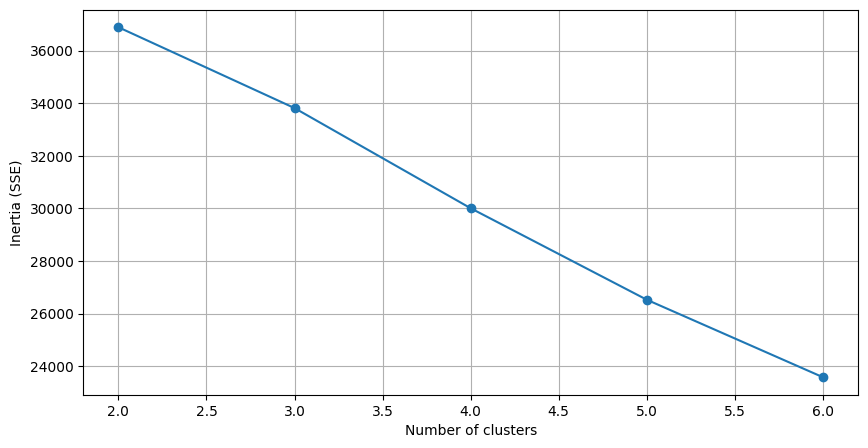

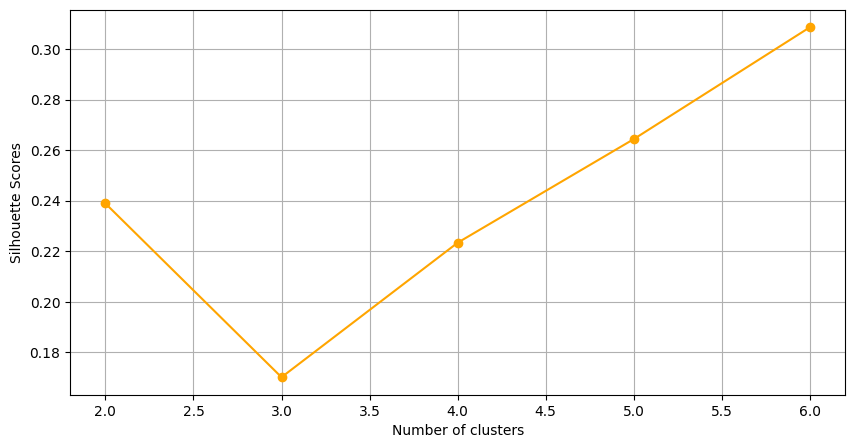

The best silhouette score was 0.30860432532774473 with a k of 6


In [ ]:
kmeans_optimization(x, 6)

In [ ]:
kmeans_eng = KMeans(n_clusters=6, random_state=42)
labels_eng = kmeans_eng.fit_predict(x)
final_df['cluster_label'] = labels_eng

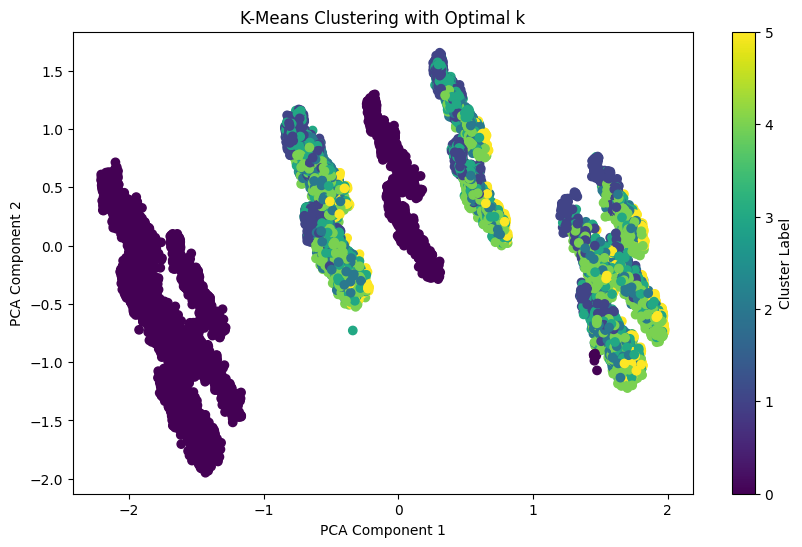

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(pca_df[:, 0], pca_df[:, 1], c=labels_eng, cmap='viridis')
plt.title('K-Means Clustering with Optimal k')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

## Classification

In [16]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
df.columns

Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'studied_credits_x', 'disability', 'num_of_prev_attempts',
       'final_result', 'module_presentation_length', 'total_clicks',
       'assessment_type', 'weight', 'score', 'registration', 'submission'],
      dtype='object')

Proviamo a rimuovere features non interessanti.

In [17]:
df['final_result'] = np.where(df['final_result'] == 'Distinction', 'Pass', df['final_result'])

In [ ]:
# Si utilizza per la variabile target
from sklearn.preprocessing import LabelEncoder
lab_encoder = LabelEncoder()
df['titleType'] = lab_encoder.fit_transform(df['titleType'])

In [71]:
svc = SVC(C= 1, kernel='rbf')
dt = DecisionTreeClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
logistic = LogisticRegression(C = 1, solver = 'lbfgs')
dummy = GaussianNB()

In [72]:
# Divisione train/test
X = final_df.drop(columns= ['final_result_Fail', 'final_result_Pass',
       'final_result_Withdrawn', 'final_result_Distinction'])
y = df['final_result']

In [73]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [74]:
models = {
    'SVM': svc,
    'Logistic Regression': logistic,
    'KNN': knn,
    'GaussianNB': dummy,
    'Decision Tree': dt,
    'Random Forest': rfc,
    'GradientBoost': gbc
}

In [75]:
train_accuracies = {}
val_accuracies = {}

train_f1s = {}
val_f1s = {}

In [76]:
for name, model in models.items():

    features_train, features_val, targets_train, targets_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

    model.fit(features_train, targets_train)

    y_train_pred = model.predict(features_train)
    y_val_pred = model.predict(features_val)

    train_accuracy = accuracy_score(targets_train, y_train_pred)
    val_accuracy = accuracy_score(targets_val, y_val_pred)

    train_f1 = f1_score(targets_train, y_train_pred, average='weighted')
    val_f1 = f1_score(targets_val, y_val_pred, average='weighted')

    train_accuracies[f'{name}'] = train_accuracy
    val_accuracies[f'{name}'] = val_accuracy

    train_f1s[f'{name}'] = train_f1
    val_f1s[f'{name}'] = val_f1

    print(name)
    print('Classification Report for train')
    print(classification_report(targets_train, y_train_pred))
    print('Classification Report for validation')
    print(classification_report(targets_val, y_val_pred))

    print('*'*50)


SVM
Classification Report for train
              precision    recall  f1-score   support

           0       0.53      0.51      0.52      3020
           1       0.77      0.95      0.85      8070
           2       0.76      0.08      0.15      1982

    accuracy                           0.71     13072
   macro avg       0.69      0.51      0.51     13072
weighted avg       0.71      0.71      0.67     13072

Classification Report for validation
              precision    recall  f1-score   support

           0       0.47      0.46      0.47       757
           1       0.76      0.94      0.84      2013
           2       0.56      0.04      0.07       498

    accuracy                           0.69      3268
   macro avg       0.60      0.48      0.46      3268
weighted avg       0.66      0.69      0.64      3268

**************************************************
Logistic Regression
Classification Report for train
              precision    recall  f1-score   support

       

/Users/laviniarotellini/Desktop/Seminario/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KNN
Classification Report for train
              precision    recall  f1-score   support

           0       0.58      0.61      0.59      3020
           1       0.81      0.91      0.85      8070
           2       0.70      0.29      0.41      1982

    accuracy                           0.74     13072
   macro avg       0.70      0.60      0.62     13072
weighted avg       0.74      0.74      0.73     13072

Classification Report for validation
              precision    recall  f1-score   support

           0       0.39      0.41      0.40       757
           1       0.75      0.86      0.80      2013
           2       0.37      0.12      0.18       498

    accuracy                           0.64      3268
   macro avg       0.50      0.46      0.46      3268
weighted avg       0.61      0.64      0.61      3268

**************************************************
GaussianNB
Classification Report for train
              precision    recall  f1-score   support

           0    

In [77]:
results_df = pd.DataFrame({
    'Model': list(train_accuracies.keys()),
    'Train Accuracy': list(train_accuracies.values()),
    'Validation Accuracy': list(val_accuracies.values()),
    'Train F1score': list(train_f1s.values()),
    'Validation F1score': list(val_f1s.values())
})

In [78]:
results_df = results_df.sort_values(by='Validation F1score', ascending=False)
results_df

,Model,Train Accuracy,Validation Accuracy,Train F1score,Validation F1score
6,GradientBoost,0.809440,0.786108,0.800575,0.774032
5,Random Forest,1.000000,0.771420,1.000000,0.755769
4,Decision Tree,1.000000,0.724908,1.000000,0.724558
1,Logistic Regression,0.704177,0.702876,0.677374,0.675279
0,SVM,0.714504,0.690942,0.666094,0.635742
2,KNN,0.744569,0.643513,0.726760,0.613687
3,GaussianNB,0.469706,0.471236,0.470353,0.469489


### Testing sui modelli migliori

In [79]:
from sklearn.model_selection import RandomizedSearchCV

In [80]:
gboost_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators' : [10, 100, 1000],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 3, 5, 10],
    'max_depth': [None, 3, 5, 10], 
    'ccp_alpha': [0, 1] 

}

grid_gboost = RandomizedSearchCV(GradientBoostingClassifier(),
                                 gboost_params,
                                 cv = 5,
                                 scoring = 'accuracy',
                                 n_jobs=-1,
                                verbose=1 )

grid_gboost.fit(x_train, y_train)
print(grid_gboost.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_depth': 3, 'learning_rate': 0.1, 'ccp_alpha': 0}


In [87]:
gb_model = GradientBoostingClassifier(**grid_gboost.best_params_, random_state=42)
gb_model.fit(x_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [82]:
model_path = "/Applications/OneDrive.app"
import joblib

In [83]:
#joblib.dump(
#    gb_model,
#    model_path + 'gb_seminario'+ '.pkl'
#)

In [ ]:
#gb_model = joblib.load('/Applications/OneDrive.appgb_seminario.pkl')

In [88]:
y_pred_gb = gb_model.predict(x_test)
print('Classification Report per Gradient Boosting Classifier')
print(classification_report(y_test, y_pred_gb))
print(f'Accuracy del GBClassifier: {accuracy_score(y_test, y_pred_gb)}')
print(f'F1 Score del GBClassifier: {f1_score(y_test, y_pred_gb, average="weighted")}')

Classification Report per Gradient Boosting Classifier
              precision    recall  f1-score   support

           0       0.56      0.48      0.52      1619
           1       0.87      0.96      0.91      4322
           2       0.60      0.48      0.54      1063

    accuracy                           0.78      7004
   macro avg       0.68      0.64      0.66      7004
weighted avg       0.76      0.78      0.76      7004

Accuracy del GBClassifier: 0.7762707024557396
F1 Score del GBClassifier: 0.7641852414168738


In [89]:
feature_names = X.columns.tolist()
feature_importances = gb_model.feature_importances_

# Crea un DataFrame per visualizzare meglio
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

importance_df.head(20)

,feature,importance
3,weight,0.442788
4,score,0.195455
41,total_clicks_very_low,0.178351
42,assessment_type_CMA,0.049797
44,assessment_type_TMA,0.036621
2,module_presentation_length,0.019579
50,submission_late_submission,0.013443
39,total_clicks_low,0.011899
0,studied_credits_x,0.010303
40,total_clicks_very_high,0.006294


In [90]:
n_classes = len(gb_model.classes_)
n_features = X.shape[1]

# Importanza per classe
importances_per_class = []

# clf.estimators_ è un array (n_classes, n_estimators)
for k in range(n_classes):
    class_importances = sum(tree.feature_importances_ for tree in gb_model.estimators_[:, k]) / gb_model.n_estimators_
    importances_per_class.append(class_importances)

# Ora hai un array per ogni classe
for i, class_imp in enumerate(importances_per_class):
    print(f"Classe {gb_model.classes_[i]} - Feature Importances:")
    print(class_imp)

Classe 0 - Feature Importances:
[0.04303057 0.05086802 0.06911899 0.21583516 0.23559531 0.01215165
 0.01832838 0.         0.00611065 0.00340194 0.         0.00947999
 0.0013937  0.01893249 0.00493561 0.01884115 0.01838368 0.00994875
 0.00232732 0.         0.001735   0.00427786 0.03144689 0.00919187
 0.01271976 0.00087104 0.00158888 0.         0.00076464 0.01658194
 0.0090194  0.00157499 0.01018772 0.         0.         0.00402096
 0.00662199 0.00121138 0.00441287 0.00617148 0.00334222 0.03991807
 0.01831194 0.         0.0128657  0.01030102 0.00238875 0.00371776
 0.00429274 0.00889726 0.00808178 0.00962769 0.01717302]
Classe 1 - Feature Importances:
[3.44520512e-03 2.61324196e-03 4.99037177e-02 5.69437965e-01
 9.11019167e-02 1.98681663e-02 1.96208716e-02 0.00000000e+00
 7.24505496e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.79143586e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.45098

In [91]:
for i, class_name in enumerate(gb_model.classes_):
    print(f"\nClasse '{class_name}' - Feature Importances ordinate:")
    
    # Crea DataFrame per ordinare le importanze
    df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances_per_class[i]
    })

    # Ordina in modo decrescente
    df_sorted = df.sort_values(by='Importance', ascending=False)

    print(df_sorted.to_string(index=False))


Classe '0' - Feature Importances ordinate:
                                      Feature  Importance
                                        score    0.235595
                                       weight    0.215835
                   module_presentation_length    0.069119
                         num_of_prev_attempts    0.050868
                            studied_credits_x    0.043031
                        total_clicks_very_low    0.039918
         highest_education_Lower Than A Level    0.031447
                              region_Scotland    0.018932
                          region_South Region    0.018841
                     region_South West Region    0.018384
                                     gender_M    0.018328
                          assessment_type_CMA    0.018312
                                cluster_label    0.017173
                              imd_band_60-70%    0.016582
                          assessment_type_TMA    0.012866
                            

In [92]:
rf_params = {
    'n_estimators': [10,100],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

grid_rf = RandomizedSearchCV(rfc, 
                             rf_params, 
                             cv = 5, 
                             scoring='accuracy',
                             n_jobs=-1, 
                             verbose = 1)


grid_rf.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,estimator,RandomForestC...ndom_state=42)
,param_distributions,"{'class_weight': [None, 'balanced'], 'max_depth': [10, 20, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,n_iter,10
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [93]:
print(grid_rf.best_params_)

{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 20, 'class_weight': None}


In [94]:
random_forest = RandomForestClassifier(**grid_rf.best_params_)
random_forest.fit(x_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [95]:
y_pred_rf = random_forest.predict(x_test)
print('Classification Report per Random Forest Classifier')
print(classification_report(y_test, y_pred_rf))
print(f'Accuracy del Random Forest Classifier: {accuracy_score(y_test, y_pred_rf)}')
print(f'F1 Score del Random Forest Classifier: {f1_score(y_test, y_pred_rf, average="weighted")}')

Classification Report per Random Forest Classifier
              precision    recall  f1-score   support

           0       0.54      0.45      0.49      1619
           1       0.84      0.97      0.90      4322
           2       0.62      0.38      0.47      1063

    accuracy                           0.76      7004
   macro avg       0.67      0.60      0.62      7004
weighted avg       0.74      0.76      0.74      7004

Accuracy del Random Forest Classifier: 0.7605653912050258
F1 Score del Random Forest Classifier: 0.7402914425481415


In [96]:
feature_importances_rf = random_forest.feature_importances_

# Crea un DataFrame per visualizzare meglio
importance_df_rf = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances_rf
}).sort_values('importance', ascending=False)

importance_df_rf.head(20)

,feature,importance
3,weight,0.262996
4,score,0.171838
41,total_clicks_very_low,0.081916
2,module_presentation_length,0.053540
52,cluster_label,0.052491
0,studied_credits_x,0.034324
44,assessment_type_TMA,0.027425
42,assessment_type_CMA,0.027078
40,total_clicks_very_high,0.019821
50,submission_late_submission,0.016485


In [97]:
n_classes_forest = len(random_forest.classes_)

# Inizializza matrice [n_classes x n_features]
class_feature_importances = np.zeros((n_classes, n_features))

# Per ogni albero
for tree in random_forest.estimators_:
    tree_ = tree.tree_
    for node in range(tree_.node_count):
        # Se non è una foglia
        if tree_.feature[node] >= 0:
            feature = tree_.feature[node]
            impurity_decrease = (
                tree_.impurity[node]
                - tree_.impurity[tree_.children_left[node]] * tree_.weighted_n_node_samples[tree_.children_left[node]] / tree_.weighted_n_node_samples[node]
                - tree_.impurity[tree_.children_right[node]] * tree_.weighted_n_node_samples[tree_.children_right[node]] / tree_.weighted_n_node_samples[node]
            )

            # Distribuzione della classe in questo nodo
            class_counts = tree_.value[node][0]
            class_distribution = class_counts / class_counts.sum()

            # Aggiungi l'impurity decrease pesata per ogni classe
            for c in range(n_classes_forest):
                class_feature_importances[c, feature] += impurity_decrease * class_distribution[c]

# Normalizza
class_feature_importances /= class_feature_importances.sum(axis=1, keepdims=True)

# Mostra i risultati
for i, class_name in enumerate(random_forest.classes_):
    print(f"\nClasse '{class_name}' - Feature Importances:")
    for name, val in zip(feature_names, class_feature_importances[i]):
        print(f"{name}: {val:.4f}")


Classe '0' - Feature Importances:
studied_credits_x: 0.0576
num_of_prev_attempts: 0.0183
module_presentation_length: 0.0960
weight: 0.1877
score: 0.1880
gender_F: 0.0189
gender_M: 0.0198
region_East Anglian Region: 0.0066
region_East Midlands Region: 0.0037
region_Ireland: 0.0016
region_London Region: 0.0056
region_North Region: 0.0022
region_North Western Region: 0.0048
region_Scotland: 0.0063
region_South East Region: 0.0026
region_South Region: 0.0050
region_South West Region: 0.0037
region_Wales: 0.0044
region_West Midlands Region: 0.0044
region_Yorkshire Region: 0.0025
highest_education_A Level or Equivalent: 0.0239
highest_education_HE Qualification: 0.0091
highest_education_Lower Than A Level: 0.0238
imd_band_0-10%: 0.0088
imd_band_10-20: 0.0099
imd_band_20-30%: 0.0083
imd_band_30-40%: 0.0066
imd_band_40-50%: 0.0058
imd_band_50-60%: 0.0060
imd_band_60-70%: 0.0054
imd_band_70-80%: 0.0044
imd_band_80-90%: 0.0036
imd_band_90-100%: 0.0033
age_band_0-35: 0.0198
age_band_35+: 0.0200


In [98]:
for i, class_name in enumerate(gb_model.classes_):
    print(f"\nClasse '{class_name}' - Feature Importances ordinate:")
    
    # Crea DataFrame per ordinare le importanze
    df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances_per_class[i]
    })

    # Ordina in modo decrescente
    df_sorted = df.sort_values(by='Importance', ascending=False)

    print(df_sorted.to_string(index=False))


Classe '0' - Feature Importances ordinate:
                                      Feature  Importance
                                        score    0.235595
                                       weight    0.215835
                   module_presentation_length    0.069119
                         num_of_prev_attempts    0.050868
                            studied_credits_x    0.043031
                        total_clicks_very_low    0.039918
         highest_education_Lower Than A Level    0.031447
                              region_Scotland    0.018932
                          region_South Region    0.018841
                     region_South West Region    0.018384
                                     gender_M    0.018328
                          assessment_type_CMA    0.018312
                                cluster_label    0.017173
                              imd_band_60-70%    0.016582
                          assessment_type_TMA    0.012866
                            